In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
device = torch.device('cuda')
device

device(type='cuda')

In [4]:
df = pd.read_csv('/content/gdrive/My Drive/age_gender.csv')

df['pixels'] = df['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype='float32'))

train_size = int(df.shape[0] * 0.7)
df = df.sample(frac=1)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

X_train = torch.from_numpy(np.vstack(train_df['pixels'].values / 255)).view(-1, 48, 48).unsqueeze(1)
X_test = torch.from_numpy(np.vstack(test_df['pixels'].values / 255)).view(-1, 48, 48).unsqueeze(1)

In [5]:
# age prediction
y_train = train_df['age'].values
y_test = test_df['age'].values
y_train = torch.from_numpy(y_train).unsqueeze(1).float()
y_test = torch.from_numpy(y_test).unsqueeze(1).float()

tensor([4.])

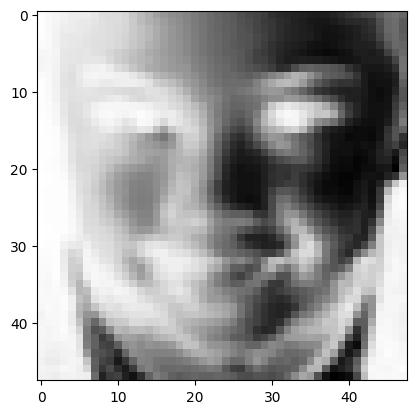

In [6]:
plt.imshow(X_train[33].squeeze(0), cmap='Greys')
y_train[33]

In [7]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
for img, label in train_loader:
    print(img.shape, label.shape)
    break

torch.Size([32, 1, 48, 48]) torch.Size([32, 1])


In [14]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),

    nn.Linear(256 * 6 * 6, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 1),
)

model.to(device)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=9216, out_features=1024, bias=True)
  (14): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
n_epochs = 30
best_test_loss = float('inf')

for epoch in range(n_epochs):
    model.train()
    loss_train = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        pred = model(images)
        loss = loss_fn(pred, labels)
        loss_train += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    loss_train /= len(train_loader)

    model.eval()
    with torch.no_grad():
        loss_test = 0
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            pred = model(images)
            loss = loss_fn(pred, labels)
            loss_test += loss.item()

    loss_test /= len(test_loader)

    print(f'epoch [{epoch + 1}/{n_epochs}], train loss: {loss_train:.4f}, test loss: {loss_test:.4f}')

    if loss_test <= best_test_loss:
        best_test_loss = loss_test
        torch.save(model, 'age_model.pth')
        print('best model saved')

100%|██████████| 223/223 [00:00<00:00, 347.46it/s]


epoch [1/30], train loss: 296.3901, test loss: 105.8185
best model saved


100%|██████████| 223/223 [00:00<00:00, 347.52it/s]


epoch [2/30], train loss: 116.4243, test loss: 94.1312
best model saved


100%|██████████| 223/223 [00:00<00:00, 345.85it/s]


epoch [3/30], train loss: 97.9208, test loss: 90.0982
best model saved


100%|██████████| 223/223 [00:00<00:00, 348.27it/s]


epoch [4/30], train loss: 85.4998, test loss: 161.1476


100%|██████████| 223/223 [00:00<00:00, 265.95it/s]


epoch [5/30], train loss: 75.8985, test loss: 80.1939
best model saved


100%|██████████| 223/223 [00:00<00:00, 343.33it/s]


epoch [6/30], train loss: 66.4659, test loss: 83.6944


100%|██████████| 223/223 [00:00<00:00, 347.67it/s]


epoch [7/30], train loss: 63.6317, test loss: 95.3406


100%|██████████| 223/223 [00:00<00:00, 317.56it/s]


epoch [8/30], train loss: 56.2853, test loss: 80.7633


100%|██████████| 223/223 [00:00<00:00, 350.41it/s]


epoch [9/30], train loss: 51.8270, test loss: 98.8118


100%|██████████| 223/223 [00:00<00:00, 314.79it/s]


epoch [10/30], train loss: 46.2101, test loss: 79.0480
best model saved


100%|██████████| 223/223 [00:00<00:00, 348.55it/s]


epoch [11/30], train loss: 46.1951, test loss: 74.0085
best model saved


100%|██████████| 223/223 [00:00<00:00, 329.63it/s]


epoch [12/30], train loss: 42.6412, test loss: 77.1309


100%|██████████| 223/223 [00:00<00:00, 346.06it/s]


epoch [13/30], train loss: 39.5046, test loss: 88.2435


100%|██████████| 223/223 [00:00<00:00, 327.14it/s]


epoch [14/30], train loss: 40.3408, test loss: 72.5954
best model saved


100%|██████████| 223/223 [00:00<00:00, 347.45it/s]


epoch [15/30], train loss: 36.7724, test loss: 71.6720
best model saved


100%|██████████| 223/223 [00:00<00:00, 349.03it/s]


epoch [16/30], train loss: 34.9595, test loss: 98.9506


100%|██████████| 223/223 [00:00<00:00, 349.18it/s]


epoch [17/30], train loss: 35.7502, test loss: 69.0678
best model saved


100%|██████████| 223/223 [00:00<00:00, 347.79it/s]


epoch [18/30], train loss: 32.8938, test loss: 84.7113


100%|██████████| 223/223 [00:00<00:00, 345.84it/s]


epoch [19/30], train loss: 34.1066, test loss: 92.6298


100%|██████████| 223/223 [00:00<00:00, 347.20it/s]


epoch [20/30], train loss: 33.3829, test loss: 71.9364


100%|██████████| 223/223 [00:00<00:00, 346.29it/s]


epoch [21/30], train loss: 31.8506, test loss: 72.7898


100%|██████████| 223/223 [00:00<00:00, 349.38it/s]


epoch [22/30], train loss: 33.3725, test loss: 69.3997


100%|██████████| 223/223 [00:00<00:00, 319.01it/s]


epoch [23/30], train loss: 30.0095, test loss: 68.8473
best model saved


100%|██████████| 223/223 [00:00<00:00, 350.58it/s]


epoch [24/30], train loss: 31.2274, test loss: 67.8332
best model saved


100%|██████████| 223/223 [00:00<00:00, 321.50it/s]


epoch [25/30], train loss: 29.7915, test loss: 86.2159


100%|██████████| 223/223 [00:00<00:00, 349.31it/s]


epoch [26/30], train loss: 30.1447, test loss: 73.2816


100%|██████████| 223/223 [00:00<00:00, 317.06it/s]


epoch [27/30], train loss: 29.9289, test loss: 95.1628


100%|██████████| 223/223 [00:00<00:00, 351.45it/s]


epoch [28/30], train loss: 29.9257, test loss: 71.6016


100%|██████████| 223/223 [00:00<00:00, 333.23it/s]


epoch [29/30], train loss: 27.4602, test loss: 69.3614


100%|██████████| 223/223 [00:00<00:00, 349.09it/s]

epoch [30/30], train loss: 29.6125, test loss: 69.3165
